<a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [3]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
def viz_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = exp[i]

    figure.add_subplot(rows, cols, i)
    plt.title(exp.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

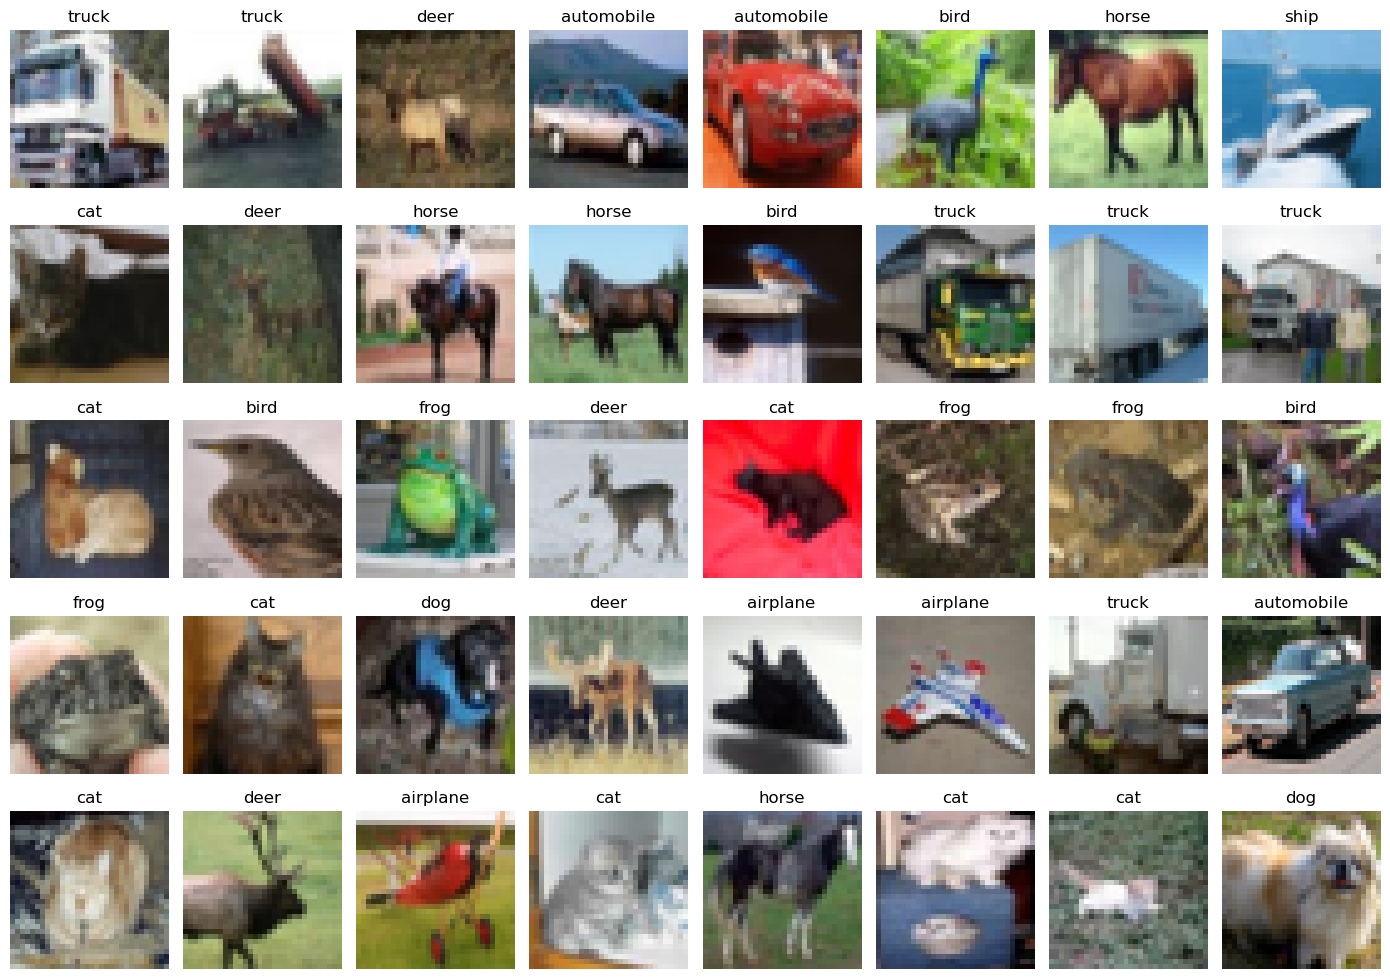

In [5]:
viz_data()

In [6]:
def show_images(aug_dict, ncol=6):
  nrow = len(aug_dict)

  fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
  for i, (key, aug) in enumerate(aug_dict.items()):
    for j in range(ncol):
      ax = axes[j,i]
      if j == 0:
        ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
      else:
        image, label = exp[j-1]
        if aug is not None:
          transform = A.Compose([aug])
          image = np.array(image)
          image = transform(image=image)['image']
          
        ax.imshow(image)
        ax.set_title(f'{exp.classes[label]}')
        ax.axis('off')

  plt.tight_layout()
  plt.show()

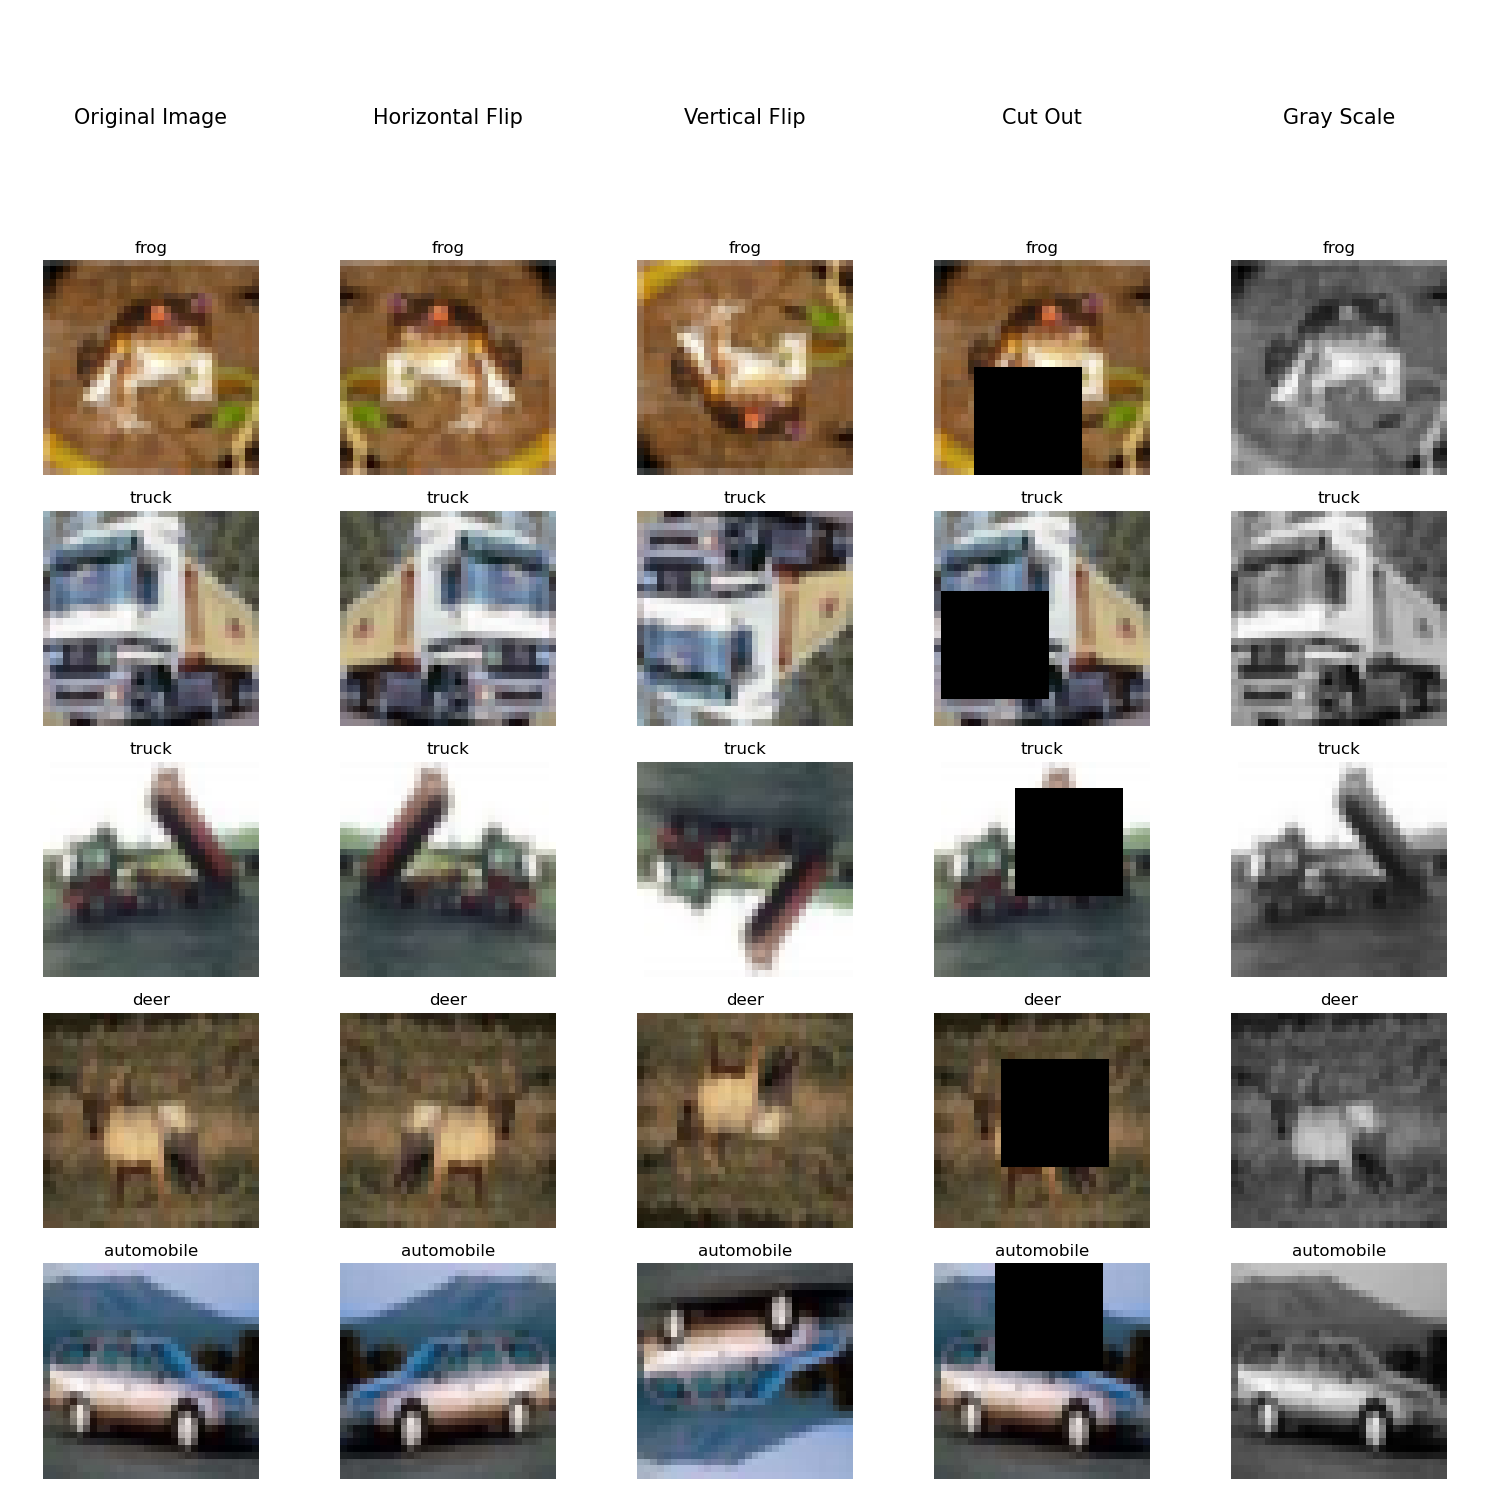

In [9]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [13]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.HorizontalFlip(),
          A.ShiftScaleRotate(),
          A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=64

print(f'Batch Size: {BATCH_SIZE}')

CUDA Available: True


In [15]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Custom_ResNet(nn.Module):
    def __init__(self):
        super(Custom_ResNet, self).__init__()
        
        self.prep_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.layer1 = self.X_seq(64, 128, 3)
        self.resblock1 = self.resblock(128, 128, 3)
        
        self.layer2 = self.X_seq(128, 256, 3, 1)
        
        self.layer3 = self.X_seq(256, 512, 3)
        self.resblock2 = self.resblock(512, 512, 3)
        
        self.pool = nn.MaxPool2d(4,4)
        self.FC = nn.Linear(512, 10, bias = False)
        
    def resblock(self, in_channels, out_channels, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv
    
    def X_seq(self, in_channels, out_channels, kernel_size, padding_val = 1):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding_val, bias=False),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv
    
    def forward(self, x):
        
        x = self.prep_layer(x) ## Input size = 32x32, output size = 32x32
        
        x = self.layer1(x) ## Input size = 32x32, output size = 16x16
        res_1 = self.resblock1(x) ## Input size = 16x16, output size = 16x16
        x = x + res_1
        
        x = self.layer2(x) ## Input size = 16x16, output size = 8x8
        
        x = self.layer3(x) ## Input size = 8x8, output size = 4x4
        res_2 = self.resblock2(x) ## Input size = 4x4, output size = 4x4
        x = x + res_2 
        
        x = self.pool(x) ## Input size = 4x4, output size = 1x1
        x = x.view(x.size(0), -1)
        x = self.FC(x)
        
        x = x.view(-1, 10)
        return F.softmax(x, dim=-1)

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Custom_ResNet().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [21]:
def train(model, device, train_loader, optimizer, l1, scheduler):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  num_loops = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    l1 = 0
    lambda_l1 = 0.01
    if l1:
      for p in model.parameter():
        l1 = l1 + p.abs().sum()
    
    loss = loss + lambda_l1*l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    num_loops += 1
    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/num_loops:.5f} Accuracy={100*correct/processed:0.2f}')
  
  return 100*correct/processed, train_loss/num_loops

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    return 100. * correct / len(test_loader.dataset), test_loss

def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test(net, device, test_loader)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [22]:
net, history = fit_model(net, NUM_EPOCHS=24)

EPOCH: 1


Batch_id=97 Loss=-0.48522 Accuracy=48.90: 100%|██████████| 98/98 [00:05<00:00, 16.67it/s]



Test set: Average loss: -0.5287, Accuracy: 5320/10000 (53.20%)

EPOCH: 2


Batch_id=97 Loss=-0.48224 Accuracy=48.73: 100%|██████████| 98/98 [00:05<00:00, 17.03it/s]



Test set: Average loss: -0.5188, Accuracy: 5215/10000 (52.15%)

EPOCH: 3


Batch_id=97 Loss=-0.47876 Accuracy=48.30: 100%|██████████| 98/98 [00:05<00:00, 16.96it/s]



Test set: Average loss: -0.5137, Accuracy: 5173/10000 (51.73%)

EPOCH: 4


Batch_id=97 Loss=-0.47724 Accuracy=48.10: 100%|██████████| 98/98 [00:05<00:00, 17.06it/s]



Test set: Average loss: -0.5213, Accuracy: 5230/10000 (52.30%)

EPOCH: 5


Batch_id=97 Loss=-0.47374 Accuracy=47.76: 100%|██████████| 98/98 [00:05<00:00, 17.27it/s]



Test set: Average loss: -0.5142, Accuracy: 5168/10000 (51.68%)

EPOCH: 6


Batch_id=97 Loss=-0.47390 Accuracy=47.81: 100%|██████████| 98/98 [00:05<00:00, 17.32it/s]



Test set: Average loss: -0.5115, Accuracy: 5133/10000 (51.33%)

EPOCH: 7


Batch_id=97 Loss=-0.47616 Accuracy=47.98: 100%|██████████| 98/98 [00:05<00:00, 17.63it/s]



Test set: Average loss: -0.5141, Accuracy: 5160/10000 (51.60%)

EPOCH: 8


Batch_id=97 Loss=-0.47546 Accuracy=47.92: 100%|██████████| 98/98 [00:05<00:00, 17.46it/s]



Test set: Average loss: -0.5231, Accuracy: 5258/10000 (52.58%)

EPOCH: 9


Batch_id=97 Loss=-0.47945 Accuracy=48.29: 100%|██████████| 98/98 [00:05<00:00, 17.84it/s]



Test set: Average loss: -0.5182, Accuracy: 5207/10000 (52.07%)

EPOCH: 10


Batch_id=97 Loss=-0.48269 Accuracy=48.60: 100%|██████████| 98/98 [00:05<00:00, 17.83it/s]



Test set: Average loss: -0.5245, Accuracy: 5268/10000 (52.68%)

EPOCH: 11


Batch_id=97 Loss=-0.48195 Accuracy=48.51: 100%|██████████| 98/98 [00:05<00:00, 17.59it/s]



Test set: Average loss: -0.5209, Accuracy: 5230/10000 (52.30%)

EPOCH: 12


Batch_id=97 Loss=-0.48630 Accuracy=48.98: 100%|██████████| 98/98 [00:05<00:00, 17.58it/s]



Test set: Average loss: -0.5179, Accuracy: 5214/10000 (52.14%)

EPOCH: 13


Batch_id=97 Loss=-0.48795 Accuracy=49.11: 100%|██████████| 98/98 [00:05<00:00, 17.45it/s]



Test set: Average loss: -0.5279, Accuracy: 5300/10000 (53.00%)

EPOCH: 14


Batch_id=97 Loss=-0.48976 Accuracy=49.33: 100%|██████████| 98/98 [00:05<00:00, 17.80it/s]



Test set: Average loss: -0.5274, Accuracy: 5299/10000 (52.99%)

EPOCH: 15


Batch_id=97 Loss=-0.49270 Accuracy=49.56: 100%|██████████| 98/98 [00:05<00:00, 17.50it/s]



Test set: Average loss: -0.5324, Accuracy: 5343/10000 (53.43%)

EPOCH: 16


Batch_id=97 Loss=-0.49237 Accuracy=49.55: 100%|██████████| 98/98 [00:05<00:00, 17.51it/s]



Test set: Average loss: -0.5338, Accuracy: 5344/10000 (53.44%)

EPOCH: 17


Batch_id=97 Loss=-0.49800 Accuracy=50.12: 100%|██████████| 98/98 [00:05<00:00, 17.40it/s]



Test set: Average loss: -0.5373, Accuracy: 5380/10000 (53.80%)

EPOCH: 18


Batch_id=97 Loss=-0.50024 Accuracy=50.36: 100%|██████████| 98/98 [00:05<00:00, 17.26it/s]



Test set: Average loss: -0.5389, Accuracy: 5416/10000 (54.16%)

EPOCH: 19


Batch_id=97 Loss=-0.50233 Accuracy=50.53: 100%|██████████| 98/98 [00:05<00:00, 17.32it/s]



Test set: Average loss: -0.5415, Accuracy: 5441/10000 (54.41%)

EPOCH: 20


Batch_id=97 Loss=-0.50623 Accuracy=50.93: 100%|██████████| 98/98 [00:05<00:00, 17.55it/s]



Test set: Average loss: -0.5433, Accuracy: 5463/10000 (54.63%)

EPOCH: 21


Batch_id=97 Loss=-0.50771 Accuracy=51.14: 100%|██████████| 98/98 [00:05<00:00, 17.70it/s]



Test set: Average loss: -0.5462, Accuracy: 5475/10000 (54.75%)

EPOCH: 22


Batch_id=97 Loss=-0.51183 Accuracy=51.46: 100%|██████████| 98/98 [00:05<00:00, 17.42it/s]



Test set: Average loss: -0.5462, Accuracy: 5480/10000 (54.80%)

EPOCH: 23


Batch_id=97 Loss=-0.51529 Accuracy=51.88: 100%|██████████| 98/98 [00:05<00:00, 17.85it/s]



Test set: Average loss: -0.5470, Accuracy: 5489/10000 (54.89%)

EPOCH: 24


Batch_id=97 Loss=-0.51365 Accuracy=51.66: 100%|██████████| 98/98 [00:05<00:00, 17.60it/s]



Test set: Average loss: -0.5472, Accuracy: 5492/10000 (54.92%)



In [23]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder


def find_lr(net, optimizer, criterion, train_loader):
    """Find learning rate for using One Cyclic LRFinder
    Args:
        net (instace): torch instace of defined model
        optimizer (instance): optimizer to be used
        criterion (instance): criterion to be used for calculating loss
        train_loader (instance): torch dataloader instace for trainig set
    """
    lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, end_lr=10, num_iter=100, step_mode="exp")
    lr_finder.plot()
    lr_finder.reset()

In [24]:
import numpy as np
import torch
from tqdm import tqdm


def train(model, device, train_loader, criterion, scheduler, optimizer, use_l1=False, lambda_l1=0.01):
    """Function to train the model

    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_loader (instance): Torch Dataloader instance for trainingset
        criterion (instance): criterion to used for calculating the loss
        scheduler (function): scheduler to be used
        optimizer (function): optimizer to be used
        use_l1 (bool, optional): L1 Regularization method set True to use . Defaults to False.
        lambda_l1 (float, optional): Regularization parameter of L1. Defaults to 0.01.

    Returns:
        float: accuracy and loss values
    """
    model.train()
    pbar = tqdm(train_loader)
    lr_trend = []
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
        # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
        # ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        # Calculate loss
        loss = criterion(y_pred, target)

        l1=0
        if use_l1:
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1*l1

        # Backpropagation
        loss.backward()
        optimizer.step()
        # updating LR
        if scheduler:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
                lr_trend.append(scheduler.get_last_lr()[0])

        train_loss += loss.item()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        

        pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/(batch_idx + 1):.5f} Accuracy={100*correct/processed:0.2f}%')
    return 100*correct/processed, train_loss/(batch_idx + 1), lr_trend


def test(model, device, test_loader, criterion):
    """put model in eval mode and test it

    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        test_loader (instance): Torch Dataloader instance for testset
        criterion (instance): criterion to used for calculating the loss

    Returns:
        float: accuracy and loss values
    """
    model.eval()
    test_loss = 0
    correct = 0
    #iteration = len(test_loader.dataset)// test_loader.batch_size
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss


def save_model(model, epoch, optimizer, path):
    """Save torch model in .pt format

    Args:
        model (instace): torch instance of model to be saved
        epoch (int): epoch num
        optimizer (instance): torch optimizer
        path (str): model saving path
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, path)


def fit_model(net, optimizer, criterion, device, NUM_EPOCHS,train_loader, test_loader, use_l1=False, scheduler=None, save_best=False):
    """Fit the model

    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        criterion (instance): criterion to used for calculating the loss
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        test_loader (instance): Torch Dataloader instance for testset
        use_l1 (bool, optional): L1 Regularization method set True to use. Defaults to False.
        scheduler (function, optional): scheduler to be used. Defaults to None.
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered

    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    lr_trend = []
    if save_best:
        min_val_loss = np.inf
        save_path = 'model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
        
        train_acc, train_loss, lr_hist = train(
            model=net, 
            device=device, 
            train_loader=train_loader, 
            criterion=criterion ,
            optimizer=optimizer, 
            use_l1=use_l1, 
            scheduler=scheduler
        )
        test_acc, test_loss = test(net, device, test_loader, criterion)
        # update LR
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
        
        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not inprove from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        lr_trend.extend(lr_hist)    

    if scheduler:   
        return net, (training_acc, training_loss, testing_acc, testing_loss, lr_trend)
    else:
        return net, (training_acc, training_loss, testing_acc, testing_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.57E-02


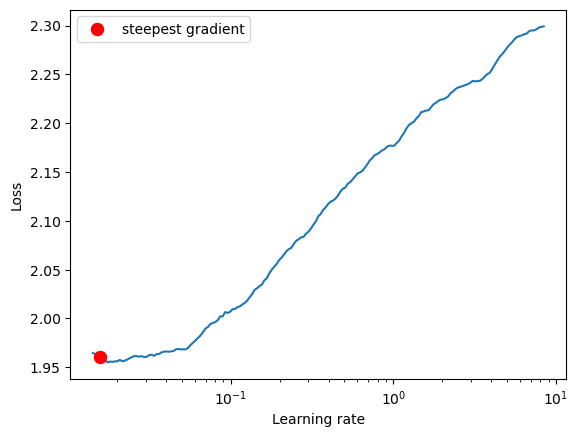

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.015702901247293774)

In [26]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [27]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.017426333860096503


In [30]:
#net3 = CNet(drop=0.0).to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=1,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.017426333860096503)


Batch_id=97 Loss=2.29020 Accuracy=17.07%: 100%|██████████| 98/98 [00:05<00:00, 16.61it/s]



Test set: Average loss: 2.2622, Accuracy: 1989/10000 (19.89%)

EPOCH: 2 (LR: 0.017426333860096503)


Batch_id=97 Loss=2.29080 Accuracy=17.00%: 100%|██████████| 98/98 [00:05<00:00, 16.80it/s]



Test set: Average loss: 2.2609, Accuracy: 2001/10000 (20.01%)

EPOCH: 3 (LR: 0.017426333860096503)


Batch_id=97 Loss=2.28724 Accuracy=17.36%: 100%|██████████| 98/98 [00:05<00:00, 17.14it/s]



Test set: Average loss: 2.2584, Accuracy: 2023/10000 (20.23%)

EPOCH: 4 (LR: 0.017426333860096503)


Batch_id=97 Loss=2.28810 Accuracy=17.27%: 100%|██████████| 98/98 [00:05<00:00, 17.08it/s]



Test set: Average loss: 2.2571, Accuracy: 2037/10000 (20.37%)

EPOCH: 5 (LR: 0.017426333860096503)


Batch_id=97 Loss=2.28763 Accuracy=17.32%: 100%|██████████| 98/98 [00:05<00:00, 17.21it/s]



Test set: Average loss: 2.2560, Accuracy: 2048/10000 (20.48%)

EPOCH: 6 (LR: 0.01723936381972255)


Batch_id=97 Loss=2.28603 Accuracy=17.49%: 100%|██████████| 98/98 [00:05<00:00, 17.25it/s]



Test set: Average loss: 2.2557, Accuracy: 2051/10000 (20.51%)

EPOCH: 7 (LR: 0.01634989469561346)


Batch_id=97 Loss=2.28542 Accuracy=17.56%: 100%|██████████| 98/98 [00:05<00:00, 17.29it/s]



Test set: Average loss: 2.2550, Accuracy: 2058/10000 (20.58%)

EPOCH: 8 (LR: 0.015460425571504366)


Batch_id=97 Loss=2.28546 Accuracy=17.54%: 100%|██████████| 98/98 [00:05<00:00, 17.74it/s]



Test set: Average loss: 2.2549, Accuracy: 2058/10000 (20.58%)

EPOCH: 9 (LR: 0.014570956447395275)


Batch_id=97 Loss=2.28401 Accuracy=17.69%: 100%|██████████| 98/98 [00:05<00:00, 18.09it/s]



Test set: Average loss: 2.2538, Accuracy: 2070/10000 (20.70%)

EPOCH: 10 (LR: 0.013681487323286182)


Batch_id=97 Loss=2.28445 Accuracy=17.63%: 100%|██████████| 98/98 [00:05<00:00, 17.87it/s]



Test set: Average loss: 2.2533, Accuracy: 2073/10000 (20.73%)

EPOCH: 11 (LR: 0.01279201819917709)


Batch_id=97 Loss=2.28336 Accuracy=17.74%: 100%|██████████| 98/98 [00:05<00:00, 17.82it/s]



Test set: Average loss: 2.2526, Accuracy: 2082/10000 (20.82%)

EPOCH: 12 (LR: 0.011902549075067999)


Batch_id=97 Loss=2.28256 Accuracy=17.82%: 100%|██████████| 98/98 [00:05<00:00, 17.48it/s]



Test set: Average loss: 2.2522, Accuracy: 2086/10000 (20.86%)

EPOCH: 13 (LR: 0.011013079950958906)


Batch_id=97 Loss=2.28075 Accuracy=18.00%: 100%|██████████| 98/98 [00:05<00:00, 18.06it/s]



Test set: Average loss: 2.2515, Accuracy: 2093/10000 (20.93%)

EPOCH: 14 (LR: 0.010123610826849812)


Batch_id=97 Loss=2.27962 Accuracy=18.12%: 100%|██████████| 98/98 [00:05<00:00, 17.61it/s]



Test set: Average loss: 2.2514, Accuracy: 2094/10000 (20.94%)

EPOCH: 15 (LR: 0.009234141702740721)


Batch_id=97 Loss=2.27963 Accuracy=18.12%: 100%|██████████| 98/98 [00:05<00:00, 17.92it/s]



Test set: Average loss: 2.2513, Accuracy: 2094/10000 (20.94%)

EPOCH: 16 (LR: 0.008344672578631628)


Batch_id=97 Loss=2.27965 Accuracy=18.11%: 100%|██████████| 98/98 [00:05<00:00, 17.73it/s]



Test set: Average loss: 2.2511, Accuracy: 2098/10000 (20.98%)

EPOCH: 17 (LR: 0.0074552034545225365)


Batch_id=97 Loss=2.27936 Accuracy=18.16%: 100%|██████████| 98/98 [00:05<00:00, 17.73it/s]



Test set: Average loss: 2.2512, Accuracy: 2096/10000 (20.96%)

EPOCH: 18 (LR: 0.006565734330413445)


Batch_id=97 Loss=2.27902 Accuracy=18.20%: 100%|██████████| 98/98 [00:05<00:00, 17.37it/s]



Test set: Average loss: 2.2513, Accuracy: 2094/10000 (20.94%)

EPOCH: 19 (LR: 0.005676265206304352)


Batch_id=97 Loss=2.27968 Accuracy=18.13%: 100%|██████████| 98/98 [00:05<00:00, 17.77it/s]



Test set: Average loss: 2.2513, Accuracy: 2095/10000 (20.95%)

EPOCH: 20 (LR: 0.004786796082195259)


Batch_id=97 Loss=2.27907 Accuracy=18.18%: 100%|██████████| 98/98 [00:05<00:00, 17.78it/s]



Test set: Average loss: 2.2511, Accuracy: 2097/10000 (20.97%)

EPOCH: 21 (LR: 0.0038973269580861673)


Batch_id=97 Loss=2.27791 Accuracy=18.30%: 100%|██████████| 98/98 [00:05<00:00, 17.53it/s]



Test set: Average loss: 2.2510, Accuracy: 2096/10000 (20.96%)

EPOCH: 22 (LR: 0.003007857833977076)


Batch_id=97 Loss=2.27821 Accuracy=18.25%: 100%|██████████| 98/98 [00:05<00:00, 18.09it/s]



Test set: Average loss: 2.2509, Accuracy: 2098/10000 (20.98%)

EPOCH: 23 (LR: 0.0021183887098679827)


Batch_id=97 Loss=2.27757 Accuracy=18.32%: 100%|██████████| 98/98 [00:05<00:00, 18.10it/s]



Test set: Average loss: 2.2509, Accuracy: 2098/10000 (20.98%)

EPOCH: 24 (LR: 0.0012289195857588912)


Batch_id=97 Loss=2.27819 Accuracy=18.27%: 100%|██████████| 98/98 [00:05<00:00, 17.76it/s]



Test set: Average loss: 2.2507, Accuracy: 2098/10000 (20.98%)



CUSTOM RESNET with depthwise separable

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Custom_ResNet(nn.Module):
    def __init__(self,drop=0.2):
        super(Custom_ResNet, self).__init__()
        
        self.prep_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.layer1 = self.X_seq(64, 128, 3)
        self.resblock1 = self.resblock(128, 128, 3)
        
        self.layer2 = self.X_seq(128, 256, 3, 1)
        
        self.layer3 = self.X_seq(256, 512, 3)
        self.resblock2 = self.resblock(512, 512, 3)
        
        self.pool = nn.MaxPool2d(4,4)
        self.FC = nn.Linear(512, 10, bias = False)
        
    def resblock(self, in_channels, out_channels, kernel_size):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv
    
    def X_seq(self, in_channels, out_channels, kernel_size, padding_val = 1):
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding_val, bias=False),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return conv
    
    def forward(self, x):
        
        x = self.prep_layer(x) ## Input size = 32x32, output size = 32x32
        
        x = self.layer1(x) ## Input size = 32x32, output size = 16x16
        res_1 = self.resblock1(x) ## Input size = 16x16, output size = 16x16
        x = x + res_1
        
        x = self.layer2(x) ## Input size = 16x16, output size = 8x8
        
        x = self.layer3(x) ## Input size = 8x8, output size = 4x4
        res_2 = self.resblock2(x) ## Input size = 4x4, output size = 4x4
        x = x + res_2 
        
        x = self.pool(x) ## Input size = 4x4, output size = 1x1
        x = x.view(x.size(0), -1)
        x = self.FC(x)
        
        x = x.view(-1, 10)
        return F.softmax(x, dim=-1)


In [39]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Custom_ResNet(drop=0.2).to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.49E-02


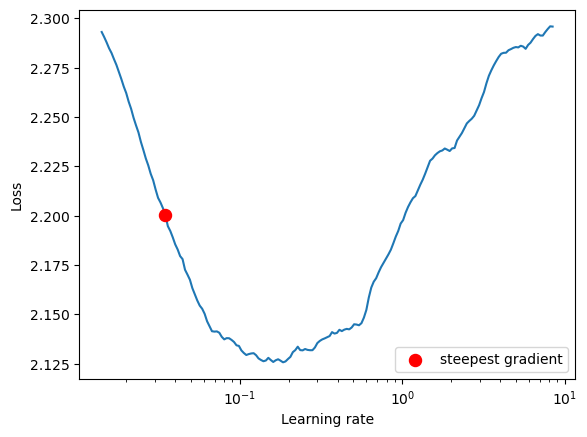

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.03489101213406773)

In [43]:
net = Custom_ResNet(drop=0.015).to(device)
import copy
net4_exp = copy.deepcopy(net)
optimizer = torch.optim.SGD(net4_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net4_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [44]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.18464249428955437


In [45]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.018464249428955436)


Batch_id=97 Loss=2.14445 Accuracy=30.87%: 100%|██████████| 98/98 [00:05<00:00, 16.63it/s]



Test set: Average loss: 2.0545, Accuracy: 4010/10000 (40.10%)

EPOCH: 2 (LR: 0.053158471832744726)


Batch_id=97 Loss=2.06993 Accuracy=38.69%: 100%|██████████| 98/98 [00:05<00:00, 16.90it/s]



Test set: Average loss: 2.0185, Accuracy: 4404/10000 (44.04%)

EPOCH: 3 (LR: 0.08785269423653402)


Batch_id=97 Loss=2.03421 Accuracy=42.21%: 100%|██████████| 98/98 [00:05<00:00, 16.86it/s]



Test set: Average loss: 1.9538, Accuracy: 5058/10000 (50.58%)

EPOCH: 4 (LR: 0.1225469166403233)


Batch_id=97 Loss=2.00711 Accuracy=44.97%: 100%|██████████| 98/98 [00:05<00:00, 16.92it/s]



Test set: Average loss: 1.9352, Accuracy: 5236/10000 (52.36%)

EPOCH: 5 (LR: 0.1572411390441126)


Batch_id=97 Loss=1.99382 Accuracy=46.34%: 100%|██████████| 98/98 [00:05<00:00, 16.91it/s]



Test set: Average loss: 1.9322, Accuracy: 5275/10000 (52.75%)

EPOCH: 6 (LR: 0.1826250473765016)


Batch_id=97 Loss=1.97462 Accuracy=48.23%: 100%|██████████| 98/98 [00:05<00:00, 16.96it/s]



Test set: Average loss: 1.8941, Accuracy: 5646/10000 (56.46%)

EPOCH: 7 (LR: 0.1730274843920758)


Batch_id=97 Loss=1.95863 Accuracy=49.96%: 100%|██████████| 98/98 [00:05<00:00, 16.87it/s]



Test set: Average loss: 1.8830, Accuracy: 5761/10000 (57.61%)

EPOCH: 8 (LR: 0.16342992140765)


Batch_id=97 Loss=1.94486 Accuracy=51.23%: 100%|██████████| 98/98 [00:05<00:00, 16.91it/s]



Test set: Average loss: 1.8528, Accuracy: 6054/10000 (60.54%)

EPOCH: 9 (LR: 0.1538323584232242)


Batch_id=97 Loss=1.92805 Accuracy=53.00%: 100%|██████████| 98/98 [00:05<00:00, 16.85it/s]



Test set: Average loss: 1.8671, Accuracy: 5922/10000 (59.22%)

EPOCH: 10 (LR: 0.1442347954387984)


Batch_id=97 Loss=1.91760 Accuracy=54.06%: 100%|██████████| 98/98 [00:05<00:00, 16.79it/s]



Test set: Average loss: 1.8247, Accuracy: 6365/10000 (63.65%)

EPOCH: 11 (LR: 0.13463723245437265)


Batch_id=97 Loss=1.90413 Accuracy=55.39%: 100%|██████████| 98/98 [00:05<00:00, 16.86it/s]



Test set: Average loss: 1.8390, Accuracy: 6212/10000 (62.12%)

EPOCH: 12 (LR: 0.12503966946994682)


Batch_id=97 Loss=1.89103 Accuracy=56.66%: 100%|██████████| 98/98 [00:05<00:00, 16.76it/s]



Test set: Average loss: 1.8386, Accuracy: 6217/10000 (62.17%)

EPOCH: 13 (LR: 0.11544210648552104)


Batch_id=97 Loss=1.88188 Accuracy=57.61%: 100%|██████████| 98/98 [00:05<00:00, 16.97it/s]



Test set: Average loss: 1.8063, Accuracy: 6547/10000 (65.47%)

EPOCH: 14 (LR: 0.10584454350109525)


Batch_id=97 Loss=1.87633 Accuracy=58.14%: 100%|██████████| 98/98 [00:05<00:00, 17.15it/s]



Test set: Average loss: 1.7912, Accuracy: 6704/10000 (67.04%)

EPOCH: 15 (LR: 0.09624698051666945)


Batch_id=97 Loss=1.86660 Accuracy=59.16%: 100%|██████████| 98/98 [00:05<00:00, 16.81it/s]



Test set: Average loss: 1.7859, Accuracy: 6742/10000 (67.42%)

EPOCH: 16 (LR: 0.08664941753224366)


Batch_id=97 Loss=1.86133 Accuracy=59.72%: 100%|██████████| 98/98 [00:05<00:00, 16.73it/s]



Test set: Average loss: 1.7832, Accuracy: 6766/10000 (67.66%)

EPOCH: 17 (LR: 0.07705185454781785)


Batch_id=97 Loss=1.85095 Accuracy=60.80%: 100%|██████████| 98/98 [00:05<00:00, 16.72it/s]



Test set: Average loss: 1.7680, Accuracy: 6930/10000 (69.30%)

EPOCH: 18 (LR: 0.06745429156339207)


Batch_id=97 Loss=1.84141 Accuracy=61.78%: 100%|██████████| 98/98 [00:05<00:00, 16.96it/s]



Test set: Average loss: 1.7588, Accuracy: 7016/10000 (70.16%)

EPOCH: 19 (LR: 0.05785672857896626)


Batch_id=97 Loss=1.83647 Accuracy=62.21%: 100%|██████████| 98/98 [00:05<00:00, 16.65it/s]



Test set: Average loss: 1.7523, Accuracy: 7082/10000 (70.82%)

EPOCH: 20 (LR: 0.048259165594540465)


Batch_id=97 Loss=1.82598 Accuracy=63.33%: 100%|██████████| 98/98 [00:05<00:00, 16.70it/s]



Test set: Average loss: 1.7400, Accuracy: 7199/10000 (71.99%)

EPOCH: 21 (LR: 0.03866160261011467)


Batch_id=97 Loss=1.82019 Accuracy=63.87%: 100%|██████████| 98/98 [00:05<00:00, 16.63it/s]



Test set: Average loss: 1.7404, Accuracy: 7201/10000 (72.01%)

EPOCH: 22 (LR: 0.029064039625688876)


Batch_id=97 Loss=1.80971 Accuracy=64.94%: 100%|██████████| 98/98 [00:05<00:00, 16.94it/s]



Test set: Average loss: 1.7289, Accuracy: 7312/10000 (73.12%)

EPOCH: 23 (LR: 0.01946647664126308)


Batch_id=97 Loss=1.80296 Accuracy=65.68%: 100%|██████████| 98/98 [00:05<00:00, 16.92it/s]



Test set: Average loss: 1.7236, Accuracy: 7366/10000 (73.66%)

EPOCH: 24 (LR: 0.009868913656837286)


Batch_id=97 Loss=1.79521 Accuracy=66.42%: 100%|██████████| 98/98 [00:05<00:00, 16.64it/s]



Test set: Average loss: 1.7214, Accuracy: 7380/10000 (73.80%)



In [46]:
misclassified_images = helpers.wrong_predictions(model, testloader, device)
helpers.plot_misclassified(misclassified_images, mean, std, 20)

NameError: name 'helpers' is not defined